# Final evaluation of the White-Noise denoising Autoencoder

Question: Does the Autoencoder reduce the variance of the QC data in the PCA (means denoising of white noise)?  Does normalization of the data yield the same results? Is Autoencoder better than Normalization of the spectra?

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers
import pandas as pd

Loading and preprocessing the data

In [2]:
train = np.loadtxt("qcs_gen10000.txt", delimiter=",")
test = np.loadtxt("qcs_real.txt", delimiter=",")

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler_test = StandardScaler()
standardscaler_train = StandardScaler()
test_standardscaled = standardscaler_test.fit_transform(test)
train = standardscaler_train.fit_transform(train)

In [3]:
#normalizing the data
from sklearn.preprocessing import normalize
test_normalized = normalize(test_standardscaled, norm='l2')

In [4]:
train = train.reshape(train.shape[0],train.shape[1],1)
test_scaled = test_standardscaled.reshape(test_standardscaled.shape[0],test_standardscaled.shape[1],1)

Defining and training the model

In [5]:
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/
activation = "elu"
filter_size = 53
strides = 2
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(num_filters4, filter_size, strides))
model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))  

print(model.summary())

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 525, 128)          6912      
                                                                 
 conv1d_1 (Conv1D)           (None, 237, 64)           434240    
                                                                 
 conv1d_2 (Conv1D)           (None, 93, 32)            108576    
                                                                 
 conv1d_3 (Conv1D)           (None, 21, 16)            27152     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 93, 32)           27168     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 237, 64)          108608    
 ranspose)                                      

In [6]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
71/71 [==============================] - 153s 2s/step - loss: 0.4417 - val_loss: 0.1785 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 144s 2s/step - loss: 0.1503 - val_loss: 0.1337 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 99s 1s/step - loss: 0.1342 - val_loss: 0.1198 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 65s 914ms/step - loss: 0.1123 - val_loss: 0.1113 - lr: 0.0010
Epoch 5/50
71/71 [==============================] - 73s 1s/step - loss: 0.1055 - val_loss: 0.1024 - lr: 0.0010
Epoch 6/50
71/71 [==============================] - 73s 1s/step - loss: 0.0992 - val_loss: 0.0988 - lr: 0.0010
Epoch 7/50
71/71 [==============================] - 70s 987ms/step - loss: 0.0934 - val_loss: 0.0930 - lr: 0.0010
Epoch 8/50
71/71 [==============================] - 72s 1s/step - loss: 0.0952 - val_loss: 0.0900 - lr: 0.0010
Epoch 9/50
71/71 [==============================] - 78s 1s/step - loss: 0.0869 - val_loss: 0.0871 - lr: 

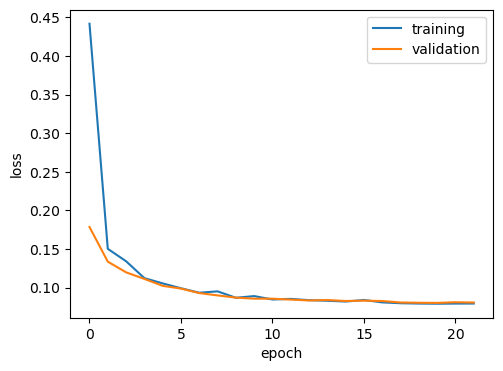

In [7]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [8]:
preds = model.predict(test_scaled, verbose=1)
preds_rescaled = standardscaler_test.inverse_transform(tf.squeeze(preds))

48/48 [==============================] - 4s 89ms/step


removing 480


Text(0, 0.5, 'principal component 2')

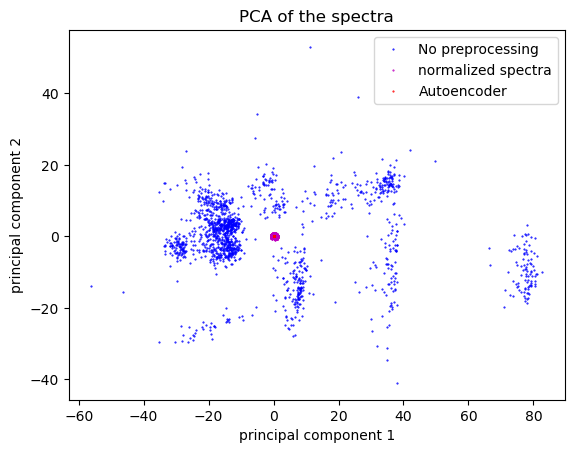

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(preds_rescaled)
principalComponents_raw = pca.fit_transform(test_standardscaled)
principalComponents_normalized = pca.fit_transform(test_normalized)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf_raw = pd.DataFrame(data = principalComponents_raw, columns = ['principal component 1', 'principal component 2'])
principalDf_normalized = pd.DataFrame(data = principalComponents_normalized, columns = ['principal component 1', 'principal component 2'])

xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_raw = list(principalDf_raw["principal component 1"])
yaxis_raw = list(principalDf_raw["principal component 2"])
xaxis_normalized = list(principalDf_normalized["principal component 1"])
yaxis_normalized = list(principalDf_normalized["principal component 2"])

remove = []
for i in range(len(xaxis_raw)):
    if xaxis_raw[i]>100:
        remove.append(i)

for i in remove:
    xaxis_raw.pop(i)
    yaxis_raw.pop(i)
    print(f"removing {i}")


plt.plot(xaxis_raw, yaxis_raw, 'bo', label='No preprocessing', markersize= 0.5)
plt.plot(xaxis_normalized, yaxis_normalized, 'mo', label = 'normalized spectra', markersize=0.5)
plt.plot(xaxis, yaxis, 'ro', label='Autoencoder', markersize= 0.5)

plt.title("PCA of the spectra")
plt.legend()
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")

Text(0.5, 1.0, 'PCA of normalized spectra and autoencoder spectra')

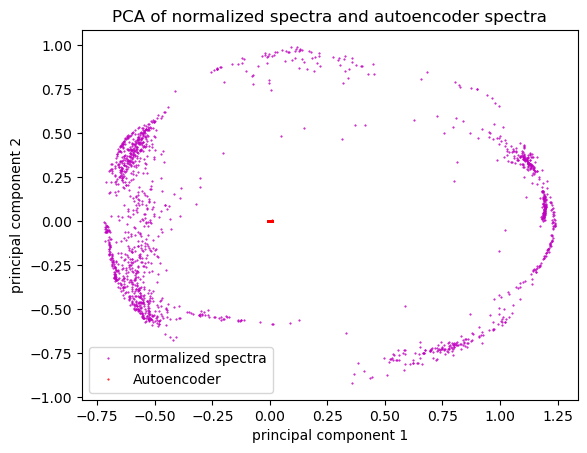

In [10]:
plt.plot(xaxis_normalized, yaxis_normalized, 'mo', label = 'normalized spectra', markersize=0.5)
plt.plot(xaxis, yaxis, 'ro', label='Autoencoder', markersize= 0.5)

plt.title("PCA of the spectra")
plt.legend()
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.title("PCA of normalized spectra and autoencoder spectra")

Text(0.5, 1.0, 'PCA of autoencoder spectra')

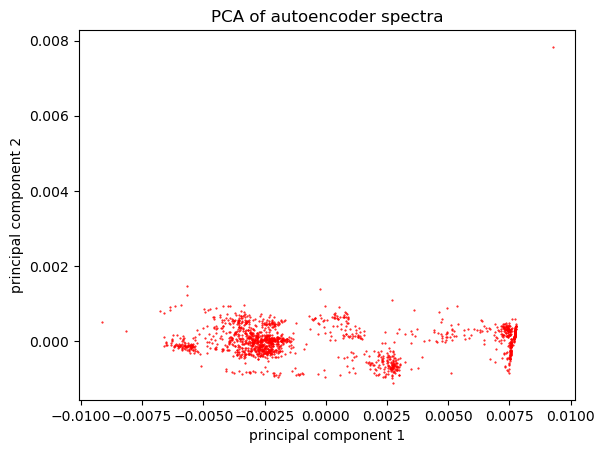

In [11]:
plt.plot(xaxis, yaxis, 'ro', label='Autoencoder', markersize= 0.5)

plt.title("PCA of the spectra")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.title("PCA of autoencoder spectra")

In [16]:
#extracting the silent regions
vec = pd.read_csv(r"\\z-sv-pool12c\pool12c_home\c\Corinna.Wegner\Documents\sample.txt", sep='\t')
vec = vec.X
vec_ = vec.to_list()

range_silent = [1800, 2300]

for i in range(len(vec_)):
    if vec_[i]<range_silent[0] and vec[i+1]>=range_silent[0]:
        min_index = i+1
    if vec_[i]<=range_silent[1] and vec[i+1]>range_silent[1]:
        max_index = i
        
silent_region_autoencoder = [spect[min_index:max_index] for spect in preds_rescaled]
silent_region_autoencoder = np.array(silent_region_autoencoder)
silent_region_normalized = [spect[min_index:max_index] for spect in test_normalized]
silent_region_normalized = np.array(silent_region_normalized)
silent_region_no = [spect[min_index:max_index] for spect in test_standardscaled]
silent_region_nopreprocessing = np.array(silent_region_no)

In [19]:
#PCA comparison of silent regions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(silent_region_autoencoder)
principalComponents_raw = pca.fit_transform(silent_region_nopreprocessing)
principalComponents_normalized = pca.fit_transform(silent_region_normalized)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf_raw = pd.DataFrame(data = principalComponents_raw, columns = ['principal component 1', 'principal component 2'])
principalDf_normalized = pd.DataFrame(data = principalComponents_normalized, columns = ['principal component 1', 'principal component 2'])

xaxis_silent = list(principalDf["principal component 1"])
yaxis_silent = list(principalDf["principal component 2"])
xaxis_raw_silent = list(principalDf_raw["principal component 1"])
yaxis_raw_silent = list(principalDf_raw["principal component 2"])
xaxis_normalized_silent = list(principalDf_normalized["principal component 1"])
yaxis_normalized_silent = list(principalDf_normalized["principal component 2"])

remove_silent = []
for i in range(len(xaxis_raw_silent)):
    if xaxis_raw_silent[i]>100:
        remove_silent.append(i)

for i in remove_silent:
    xaxis_raw_silent.pop(i)
    yaxis_raw_silent.pop(i)
    print(f"removing {i}")

removing 480


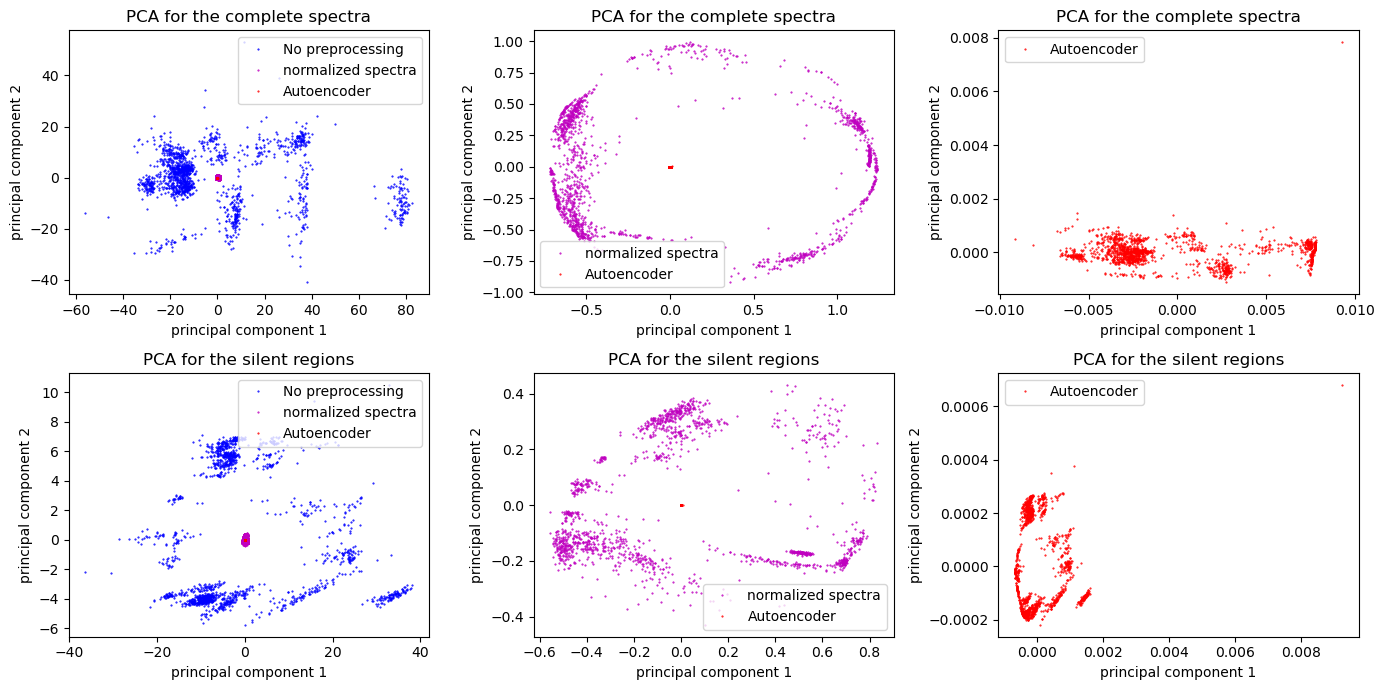

In [31]:
alpha= 7
fig, ax = plt.subplots(2, 3, figsize=(2 * alpha, 1*alpha))

#complete spectra
ax[0][0].plot(xaxis_raw, yaxis_raw, 'bo', label='No preprocessing', markersize= 0.5)
ax[0][0].plot(xaxis_normalized, yaxis_normalized, 'mo', label = 'normalized spectra', markersize=0.5)
ax[0][0].plot(xaxis, yaxis, 'ro', label='Autoencoder', markersize= 0.5)
ax[0][0].set_title("PCA for the complete spectra")


ax[0][0].legend()
ax[0][0].set_xlabel("principal component 1")
ax[0][0].set_ylabel("principal component 2")

ax[0][1].plot(xaxis_normalized, yaxis_normalized, 'mo', label = 'normalized spectra', markersize=0.5)
ax[0][1].plot(xaxis, yaxis, 'ro', label='Autoencoder', markersize= 0.5)


ax[0][1].legend()
ax[0][1].set_xlabel("principal component 1")
ax[0][1].set_ylabel("principal component 2")
ax[0][1].set_title("PCA for the complete spectra")


ax[0][2].plot(xaxis, yaxis, 'ro', label='Autoencoder', markersize= 0.5)


ax[0][2].set_xlabel("principal component 1")
ax[0][2].set_ylabel("principal component 2")
ax[0][2].legend()
ax[0][2].set_title("PCA for the complete spectra")


#only the silent regions
ax[1][0].plot(xaxis_raw_silent, yaxis_raw_silent, 'bo', label='No preprocessing', markersize= 0.5)
ax[1][0].plot(xaxis_normalized_silent, yaxis_normalized_silent, 'mo', label = 'normalized spectra', markersize=0.5)
ax[1][0].plot(xaxis_silent, yaxis_silent, 'ro', label='Autoencoder', markersize= 0.5)
ax[1][0].set_title("PCA for the silent regions")

ax[1][0].legend()
ax[1][0].set_xlabel("principal component 1")
ax[1][0].set_ylabel("principal component 2")

ax[1][1].plot(xaxis_normalized_silent, yaxis_normalized_silent, 'mo', label = 'normalized spectra', markersize=0.5)
ax[1][1].plot(xaxis_silent, yaxis_silent, 'ro', label='Autoencoder', markersize= 0.5)


ax[1][1].legend()
ax[1][1].set_xlabel("principal component 1")
ax[1][1].set_ylabel("principal component 2")
ax[1][1].set_title("PCA for the silent regions")

ax[1][2].plot(xaxis_silent, yaxis_silent, 'ro', label='Autoencoder', markersize= 0.5)


ax[1][2].set_xlabel("principal component 1")
ax[1][2].set_ylabel("principal component 2")
ax[1][2].legend()
ax[1][2].set_title("PCA for the silent regions")

plt.tight_layout()